In [1]:
%matplotlib inline

In [2]:
import pandas as pd
import numpy as np
import geopy
import geohash
from collections import Counter

# install anvil from https://github.com/saeed-abdullah/Anvil
# pip git+https://github.com/saeed-abdullah/Anvil
import anvil
from anvil import api
import math
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import permutations, repeat
import matplotlib.patches as patches

In [3]:
import networkx as nx

In [4]:
import folium 

In [5]:
sns.set_context("poster", font_scale=1.4)

In [6]:
def compute_geo_hash(df, lat_c='lat',
                     lon_c='lon', precision=12):
    """
    Computes geohash values.
    
    Parameters
    ----------
    df : DataFrame
    lat_c : str
        Name of column containing latitude values.
        Default is `lat`.
    lon_c : str
        Name of column containing longitude values.
        Default is `lon`.
    precision : int
        Precisoin of generated geohash function.
        Take a look at geohash length and precision
        here: https://en.wikipedia.org/wiki/Geohash
        
        
    Returns
    -------
    l : iterables
        List of geohash values corresponding to the
        rows of values in the given dataframe
    """
    
    
    # get geohash data
    l = []
    for _, row in df.iterrows():
        g = geohash.encode(latitude=row[lat_c],
                           longitude=row[lon_c],
                           precision=precision)
        l.append(g)
        
    return l

In [7]:
def map_geo_hashed_value(l):
    """
    Returns a geohash -> int mapping.
    
    Geohashed values are sorted in ascending order
    and then numerical IDs are assigned.
    
    Parameters
    ----------
    l : iterables
        List of hased values. Might contian
        duplicates.
    
    Returns
    -------
    d : dict
        A dictionary with hashed values as keys
        and numerical ids as values. The dict length
        might be less than the given list if it
        contains duplicates
    """
    
    l = sorted(l)
    return {k: index for index, k in enumerate(l)}

In [8]:
def trim_geo_hash_precision(hashed_values, precision=9):
    """
    Trims geo hash precision.
    
    Parameters
    ----------
    hashed_values : Series
        Contains geohashed values as strings.
        
    precision : int
        The desired precision. If the current
        precision is smaller, then nothing is done.
    """
    
    return hashed_values.map(lambda z: z[:precision])

In [9]:
def filter_out_rare_points(points, threshold_pct=0.5):
    """
    Filters out rare points.
    
    All points with occurrences <= threshold_pct is
    considerd as rare points. All rare points are
    replaced by pd.NaN
    
    Parameters
    ----------
    points : iterables
        Instances of points
        
    threshold_pct : float
        Threshold in percentage for rare points. Any
        point occuring less than given threshold is
        considerd as a rare point. Default is 0.5%
    
    Returns
    -------
    l : list
        List where rare points are marked as pd.NaN.
    """
    
    c = Counter(points)
    total = sum(c.values())
    l = []
    for p in points:
        v = c[p]
        if v/total * 100 <= threshold_pct:
            l.append(np.nan)
        else:
            l.append(p)
    
    return l
    

In [10]:
def get_primary_location(locations, aggr_f='count',
                         geo_hash_c='geo_hash'):
    """
    Gets the primary location.
    
    Within any given duration there might be a number
    of locations visited by user. This function
    identifies the primary location from a given list
    of locations.
    
    How to define a primary location? In this case,
    we use duration of time spent by a user within
    a given duration.
    
    Parameters
    ----------
    locations : Series
        Series with geo hased values.
        
    aggr_f : str
        Aggregating function. Default is 'count' which
        will result in counting number of rows. If the
        sampling rate is somewhat consistent then just
        counting the number of times a place has been
        recorded is a good approximation of the time
        spent by a user.
        
    geo_hash_c : str
        Column name that contains geo hash values.
        
    Parameters
    ----------
    location : str
        Returns the primary location.
    """
    
    if aggr_f != 'count':
        raise ValueError('Aggregate function {0} is not supported'.format(aggr_f))

    # sorted by size of each group
    return locations.groupby(locations).size().sort_values(ascending=False).index[0]
    

In [11]:
def generate_daily_nodes(df, hash_c='geo_hash',
                         geo_hash_preicion=None,
                         shift_day_start=None,
                         rare_pt_pct_th=0.5,
                         valid_day_th=8,
                         start_date=None,
                         end_date=None,
                         **kwargs):
    """
    Parameters
    ----------
    df : DataFrame
        DataFrame with sorted DateTimeIndex.
        
    hash_c : str
        Columns containing geo hash values.
        
    geo_hash_precision : int
        Desired precision of geo hashed values. See
        `trim_geo_hash_precision` for details. If `None`,
        no trimming will happen. Default is None.
        
    shift_day_start : pd.tslib.Timedelta
        The duration by which the start of the day should
        be shifted. For example, in the original paper,
        the day starts at 3:30AM. Provided value should
        be in pd.tslib.TimeDelta (e.g., for 3:30AM start
        of the day, it should be pd.to_timedelta('3.5H')).
        Default is None.
        
    rare_pt_pct_th : float
        Threshold for rare points in percentage. See
        `filter_out_rare_points` for more details. Default
        is 0.5%. If `None`, no filtering happens.
        
    valid_day_th : int
        Minimum number of intervals for a valid day. If
        a day has < valid_day_th intervals, it will be
        discarded. Default is 8.
        
    start_date : TimeStamp
        Start date to generate nodes. If None, the minimum
        day in the DateTimeIndex will be used.
        
    end_date : TimeStamp
        End date to generate nodes. If None, 1 + maximum day
        in the DateTimeIndex will be used.
        
    kwargs
        Arbitrary keyword based arguments passed to
        `generate_nodes` (e.g., time_interval)
        
        
    Returns
    -------
    l : list
        A list containing (date, nodes) pairs. Where nodes
        are represented as a DataFrame returned by `generate_nodes`.
        
        
    Notes
    -----
        The start date and end date is used pd.date_range to
        generate list of days. So, it is important to have
        same timezone information for start_date and end_date
        as in the given DateTimeIndex.
        
    """
    
    df = df.copy().loc[:, [hash_c]]
    
    l = []
    
    if start_date is None:
        d = df.index.min()
        tz = d.tz  # timezone information
        
        start_date = pd.to_datetime(d.date()).tz_localize(tz)
        
    if end_date is None:
        d = df.index.max()
        tz = d.tz  # timezone information
        
        # maximum date + 1
        end_date = pd.to_datetime(d.date()).tz_localize(tz) + pd.to_timedelta('1D')
        
        
    # shifting start of the day
    if shift_day_start is not None:
        start_date = start_date + shift_day_start
        end_date = end_date + shift_day_start
        
        
    if geo_hash_preicion is not None:
        df[hash_c] = trim_geo_hash_precision(df[hash_c], geo_hash_preicion)
    
    # remove rare points
    if rare_pt_pct_th is not None:
        df[hash_c] = filter_out_rare_points(df[hash_c],
                                            rare_pt_pct_th)
    
    # remove NA values (potentially resulting from removing rare points)
    df = df.dropna(subset=[hash_c])
    
    days = pd.date_range(start=start_date, end=end_date, freq='1D')
    for index, rows in enumerate(anvil.utils.get_df_slices(df, days)):
        d = days[index]
        
        nodes = generate_nodes(rows[hash_c], start_time=d, **kwargs)
        
        if len(nodes) < valid_day_th:
            l.append((d, np.nan))
        else:
            l.append((d, nodes))
            
    return l

In [12]:
def generate_nodes(locations,
                   start_time,
                   end_time=None,
                   time_interval='30Min',
                   valid_interval_th=1):
    """
    Generates motif information from location data.
    
    This function follows the work of Schneider et al.
    (see http://rsif.royalsocietypublishing.org/content/10/84/20130246/)
    
    Parameters
    ----------
    
    locations : Series
        Series with sorted DateTimeIndex and geo hased values
        over a given day.
        
    start_time : pandas.tslib.Timestamp
        Start time to generate time intervals.
        
    end_time : pandas.tslib.Timestamp
        End time for generating time invervals. If None,
        it is set to 24 hours after start_time. Default
        is None.
        
    time_interval : str
        The interval duration. The default is 30 mins
        (resulting in 48 intervals per day). The argument
        is passed to `pd.date_range` as the frequency string.
        
    valid_interval_th : int
        Minimum number of records for a valid interval.
        If an interval has < valid_interval_th rows, it will
        not be considered. Default is 1.
        
    Returns
    -------
    s : Series
        Series with interval order as keys and primary location as
        values. If the interval is not valid (e.g., not having
        sufficient records), it will contain np.nan as value.
    """
    
    if end_time is None:
        end_time = start_time + pd.to_timedelta('1D')

    intervals = pd.date_range(start=start_time,
                              end=end_time, freq=time_interval)
    s = []
    
    for index, t in enumerate(anvil.utils.get_df_slices(locations,
                                             intervals)):
        debug = intervals[index]
            
        if len(t) < valid_interval_th:
            s.append({'node': np.nan, 'time': intervals[index]})
        else:
            s.append({'node': get_primary_location(t), 'time': intervals[index]})
            
    return pd.DataFrame(s)

In [13]:
def resample_location_data(df, time_delta=None,
                          duration_c='duration',
                          time_c='entry_time'):
    """
    Resamples location data.
    
    Location data from iOS client contains duration
    information. This might result in irregular intervals
    between each subsequent records. As we use frequency
    of records in `get_primary_location`, this can result
    in inconsistent results (e.g., given two instances of L1
    with 10 seconds each and one instance of L2 with 25 minutes,
    it will wrongly identify L1 as primary location). Just
    using duration is not adequate to solve this problem as
    duration might overlap multiple intervals. For example,
    in case of 30 minutes intervals, a location record starting
    at 4:15 with duration of 30 minutes needs to be split into
    two records: 4:15–4:30 and 4:30–4:45. Otherwise, the primary
    location might be wrongly attributed to a different location
    (or no location) for 4:30–5:00 interval.
    
    One way of avoiding these issues is to have somewhat uniform
    sampling. In other words, given a desired sampling rate of 1 min,
    if a row has duration of 30 minutes, then spread this record over
    30 rows where each row represent a single minute. In this case,
    the entry times of each record should be updated accrodingly (i.e.,
    entry time of i-th row should be entry_time + i-th minute) and
    the total duration should add up to 30 minutes.
    
    Parameters
    ----------
    
    df : DataFrame
    time_delta : str
        Argument passed to `pd.to_timedelta`. Default is
        1 minute.
    duration_c : str
        Duration column name. The duration must be in seconds.
    time_c : str
        Time column name. Must be in pd.Timestamp format.
        
    Returns
    -------
    DataFrame
        Returns a new dataframe with updated sampling rate.
    """

    l = []
    if time_delta is None:
        time_delta = pd.to_timedelta('60s')
    else:
        time_delta = pd.to_timedelta(time_delta)
    threshold = time_delta.total_seconds()

    for rows in df.iterrows():
        r = rows[1]
        d = r[duration_c]
        entry_time = r[time_c]
        while d > threshold:
            new_r = r.copy()
            new_r[time_c] = entry_time
            new_r[duration_c] = threshold
            l.append(new_r)

            d = d - threshold
            entry_time = entry_time + time_delta

        new_r = r.copy()
        new_r[time_c] = entry_time
        new_r[duration_c] = d
        l.append(new_r)
        
    return pd.DataFrame(l)
        

In [14]:
def generate_graph(nodes):
    """
    Generate graphs from a given series of nodes.
    
    Parameters
    ----------
    nodes : Series
        An iterable of nodes. It can contain NaN values
        
        
    Returns
    -------
    list
        A list of strings where the edges are seperated by
        whitespace (e.g., ["a b", "b c"]). It can be parsed
        by networkx.parse_edgelist.
        
        
    ToDos
    -----
        1. Only considering non-consecutive nodes (e.g.,
        what to do if seperated by NaN).
    """
    
    nodes = nodes.dropna()
    l = []
    edge_format = "{0} {1}"
    
    for x1, x2 in zip(nodes.shift(), nodes):
        if not(pd.isnull(x1) or pd.isnull(x2)):
            if x1 != x2:
                l.append(edge_format.format(x1, x2))
                
    return l
    

In [15]:
def get_geo_center(df, lat_c='latitude', lon_c='longitude'):
    """
    Calculates center of given geo points.
    
    To avoid "wrap-around" issues (near international dateline),
    this method follows [1].
    
    Parameters
    ----------
    df: DataFrame
    
    lat_c: str
        Column name containing latitudes. Default is latitude.
    lon_c: str
        Column name containing longitudes. Default is longitude
        
    Returns
    -------
    d: dict
        Keys 'latitude' and 'longitude' indicate
        the coordinates of the center point.

    [1]: https://carto.com/blog/center-of-points/
    """
    
    lat = df[lat_c]
    lon = df[lon_c]
    
    angle = math.pi / 180
    
    center_lat = math.atan2(np.mean(np.sin(lat * angle)), 
                            np.mean(np.cos(lat * angle))) * 180 / math.pi
    
    center_lon = math.atan2(np.mean(np.sin(lon * angle)), 
                            np.mean(np.cos(lon * angle))) * 180 / math.pi
    
    return {'longitude': center_lon, 'latitude': center_lat}
    
    

In [16]:
def get_stay_point(df, lat_c='latitude',
                   lon_c='longitude', dist_th=300,
                   time_th='30m'):
    """
    Calculates stay points.
    
    Stay points are determined following [1]. That is,
    if a user stays within a given radius (e.g., dist_th)
    for a given period of time (e.g., time_th), then the
    center of these points is a stay point.
    
    In this implementation, given a set of points p_k (i <= k <= j),
    where these points are sorted ascendingly in terms of occurence
    (i.e., t_k <= t_(k+1)), we take a greedy approach to
    determine if these points result in a stay point. That is, these
    points are considered for stay points if:
    
        1. distance between first (p_i) and last point (p_j) is less
    than dist_th, and
        2. the time between the first and last point is larger than the
    threshold (e.g., t_j - t_i >= time_th).
    
    
    Note that this is a greedy algorithm as we implicitly consider
    the first point as the center of a cluster (with radius of dist_th)
    which might not be the optimal choice (similar case for time duration
    calculation). However, these issues should get resolved in the
    subsequent phase (i.e., by computing stay regions).
    
    Parameters
    ----------
    df: DataFrame
        DataFrame with sorted (ascending) DateTimeIndex
        
    lat_c: str
        Column name with latitude values
    
    lon_c: str
        Column name with longitude values
        
    dist_th: float
        Distance threshold in meters. Default is 300m.
        
    time_th: str or pd.timedelta
        Time threshold that will be parsed by pd.to_timedelta.
        Default is 30 minutes.
        
        
    Returns
    -------
    stay_points : list
        A list corresponding to the rows of df. Each item
        represents the sray point ids (so points within same
        stay points will have same id). If a point is a travel point
        (i.e., does not belog to any stay points), then it will 
        have np.NaN.
        
    
    [1]: https://dl.acm.org/citation.cfm?id=1463477
    """
    
    
    index = 0
    stay_points_c = 0  # total stay points count
    stay_points = []
    
    max_len = len(df)
    time_th = pd.to_timedelta(time_th)
    
    while index < max_len:
        mem_c = 1  # current stay point members: just index
        
        # time diff between current and first members
        time_diff = pd.to_timedelta('0s')
        
        
        p_f = geopy.point.Point(latitude=df.iloc[index][lat_c],
                                longitude=df.iloc[index][lon_c])

        time_f = df.index[index]

        j = index + 1
        while j < max_len:
            p_s = geopy.point.Point(latitude=df.iloc[j][lat_c],
                                    longitude=df.iloc[j][lon_c])
            
            d = geopy.distance.GreatCircleDistance(p_f, p_s).m
            if d <= dist_th:
                mem_c += 1  # new member
                time_diff = df.index[j] - time_f  # update total time spent
                j += 1
            else:
                # spatial constrain is not met
                break
        
        
        # Check if previous points met the time threshold constraint
        if time_diff >= time_th:
            # All these points share same stay point id
            stay_points.extend([stay_points_c] * mem_c)
            stay_points_c += 1
        else:
            # these are not valid stay points
            stay_points.extend([np.nan] * mem_c)

        # points up to j has been considered
        index = j
          
    return stay_points       

In [17]:
def merge_neighboring_grid(geo_hash):
    """
    Merges neighboring grids using a greedy approach.
    
    This function sorts each grid by the number by
    frequency. A grid G is merged with K, if:
        1. G and K is neighboring grid (note that
    the definition of neighboring grid depends on
    the precision of geohash), and
        2. K has higher frequency than G.
        
    The resulting merged grid retains the geohash
    of grid with higher frequency (e.g., in previous
    example, the merged grid will have the same geohash
    of K).
    
    Note that this is a greedy approach, so there is
    no gurantee that this would result in optimal clustering.
    For example, there might be cases in which a more
    cascaded merging would be better (e.g., I -> G -> K, but
    in our approach I and K might not be merged). However, this
    serves to constraint the maximum size of the merged grid
    (e.g., 9 grids) at a time, which has been shown to be a
    better strategy by Zheng et al. (2010):
    http://portal.acm.org/citation.cfm?doid=1772690.1772795
    
    Parameters
    ----------
    geo_hash : Series
        A series with geo hashed values.
        
    
    Returns
    -------
    Series
        A new series with updated geo hash values
        after merging neighboring grids.
    """
    
    
    c =  Counter(geo_hash.dropna())
    d = {}
    
    # sort by frequency
    for z, _ in c.most_common():
        # this check is necessary as we remove
        # items dynamically
        if z in c:
            d[z] = z
            
            # go through the potential merge options
            for n in geohash.neighbors(z):
                if n in c:
                    d[n] = z
                    del c[n]  #  merged with grid z
                    
    return geo_hash.map(d)
    

In [18]:
def get_stay_region(df, stay_point_c='stay_point',
                    lat_c='latitude', lon_c='longitude',
                    precision=7):
    
    """
    Calculates stay regions.
    
    There are three steps:
    
    1. First compute the center of stay points.
    2. Compute the geohash of stay point centers
    3. Merge neighboring grids.
    
    Parameters
    ----------
    
    df : DataFrame
    
    stay_point_c : str
        Column name with stay point ids. Default
        is `stay_point_id`.
        
    lat_c : str
        Column name with latitude values. Default
        is `latitude`.
        
    lon_c : str
        Column name for longitude values. Default
        is `longitude`.
        
    precision : int
        Geo hash precision. Default is 7.
        
    Returns
    -------
    Series
        Series with stay regions where a stay region
        is defined by a geohash value.
    """
    
    centers = {}
    for k, v in df.groupby(stay_point_c):
        # get stay point centers
        center = get_geo_center(v, lat_c=lat_c, lon_c=lon_c)
        
        # now convert to geo-hash grid
        h = geohash.encode(latitude=center['latitude'],
                           longitude=center['longitude'],
                           precision=precision)
        centers[k] = h
        
    # associate same stay point centers
    # to each record
    stay_points = df[stay_point_c].map(centers)
    
    # now convert the stay points to stay regions
    return merge_neighboring_grid(stay_points)


In [19]:
def add_subplot_axes(ax,rect,axisbg='w'):
    """
    from http://stackoverflow.com/questions/17458580/embedding-small-plots-inside-subplots-in-matplotlib
    example:
    
        fig = plt.figure(figsize=(10,10))
        axes = []
        subpos = [0.2,0.6,0.3,0.3]
        x = np.linspace(-np.pi,np.pi)
        for i in range(4):
            axes.append(fig.add_subplot(2,2,i))
        for axis in axes:
            axis.set_xlim(-np.pi,np.pi)
            axis.set_ylim(-1,3)
            axis.plot(x,np.sin(x))
            subax1 = add_subplot_axes(axis,subpos)
            subax2 = add_subplot_axes(subax1,subpos)
            subax1.plot(x,np.sin(x))
            subax2.plot(x,np.sin(x))
    
    """
    fig = plt.gcf()
    box = ax.get_position()
    width = box.width
    height = box.height
    inax_position  = ax.transAxes.transform(rect[0:2])
    transFigure = fig.transFigure.inverted()
    infig_position = transFigure.transform(inax_position)    
    x = infig_position[0]
    y = infig_position[1]
    width *= rect[2]
    height *= rect[3]  
    subax = fig.add_axes([x,y,width,height],axisbg=axisbg)
#     x_labelsize = subax.get_xticklabels()[0].get_size()
#     y_labelsize = subax.get_yticklabels()[0].get_size()
#     x_labelsize *= rect[2]**0.5
#     y_labelsize *= rect[3]**0.5
#     subax.xaxis.set_tick_params(labelsize=x_labelsize)
#     subax.yaxis.set_tick_params(labelsize=y_labelsize)
    return subax

# <font color = 'red'>Multiple user: Top 5 users with the highest number of gps recods</font>

### Prepare data

In [28]:
count_info = pd.read_csv('./precision-7/count_info.csv', usecols=['uid','count']).set_index('uid')

In [36]:
test_data = count_info.ix[:5,:]
# print(test_data)
test_data = test_data.index.tolist()
# print(test_data)
prefix = './precision-7/'

### Generate motif

In [32]:
valid_daily_th = 8
# parameters
time_ths = ['15m','30m','45m']
dist_ths = [100,200,300,400]

num_daily_nodes = []
graphs_all = []

for time_th in time_ths:
    num_daily_nodes_temp = []
    graphs_all_temp = []
    for dist_th in dist_ths:
        graphs = {}
        num_daily_n = {}
        for fid in test_data:
            eureka_location_data = prefix + fid
            eureka = pd.read_csv(eureka_location_data, 
                             usecols=['time', 'longitude', 'latitude','geo_hash'])
            eureka = anvil.api.convert_time_zone(eureka, 'time')
            y = eureka.copy()
            y['stay_point'] = get_stay_point(y, dist_th = dist_th,time_th = time_th)
            y['stay_region'] = get_stay_region(y)

            nodes = generate_daily_nodes(y.dropna(subset=['stay_region']), 'stay_region',valid_day_th = 8)

            # Only retain days with enough information
            # (i.e., at least 8 non-null intervals) and start and end at the same location
            nodes_h = []
            for z in nodes:
                list_of_nodes = z[1].node.dropna().tolist()
                num_nodes = len(list_of_nodes)
#                 if (num_nodes >= 16) and (list_of_nodes[0] == list_of_nodes[-1]):
                if num_nodes > 8:
                    nodes_h.append(z)
                    num_unique_nodes = len(np.unique(list_of_nodes))
                    if num_unique_nodes in num_daily_n:
                        num_daily_n[num_unique_nodes] += 1
                    else:
                        num_daily_n[num_unique_nodes] = 0
                    

            # Equality of generated graphs
            for index, n in enumerate(nodes_h):
                found = False
                g = set(generate_graph(n[1].node)) # removes duplicates
                dg = nx.DiGraph()
                # each node in the edge is seperated by whitespace
                dg.add_edges_from([t.split() for t in g]) 
                dg = nx.freeze(dg)

                for graph in graphs:
                    if nx.is_isomorphic(graph, dg):
                        # Found an isomorphic graph
                        found = True
                        graphs[graph].append(dg)
                        break
                if not found:
                    # No isomorphic graph so far, so
                    # create a new one
                    graphs[dg] = [dg]
        num_daily_nodes_temp.append(num_daily_n)
        # Sort by motif frequency
        d = []
        for k, v in graphs.items():
            d.append({'g': k, 'total': len(v)})

        d = sorted(d, key=lambda z: z['total'], reverse=True)

        # Generate motif frequency percentage bar plot
        # (limited to top 20 motifs)
        t = pd.DataFrame(d[:20])
        t['pct'] = t.total / t.total.sum() * 100
        graphs_all_temp.append(t)
    graphs_all.append(graphs_all_temp)
    num_daily_nodes.append(num_daily_nodes_temp)

### Number of daily nodes

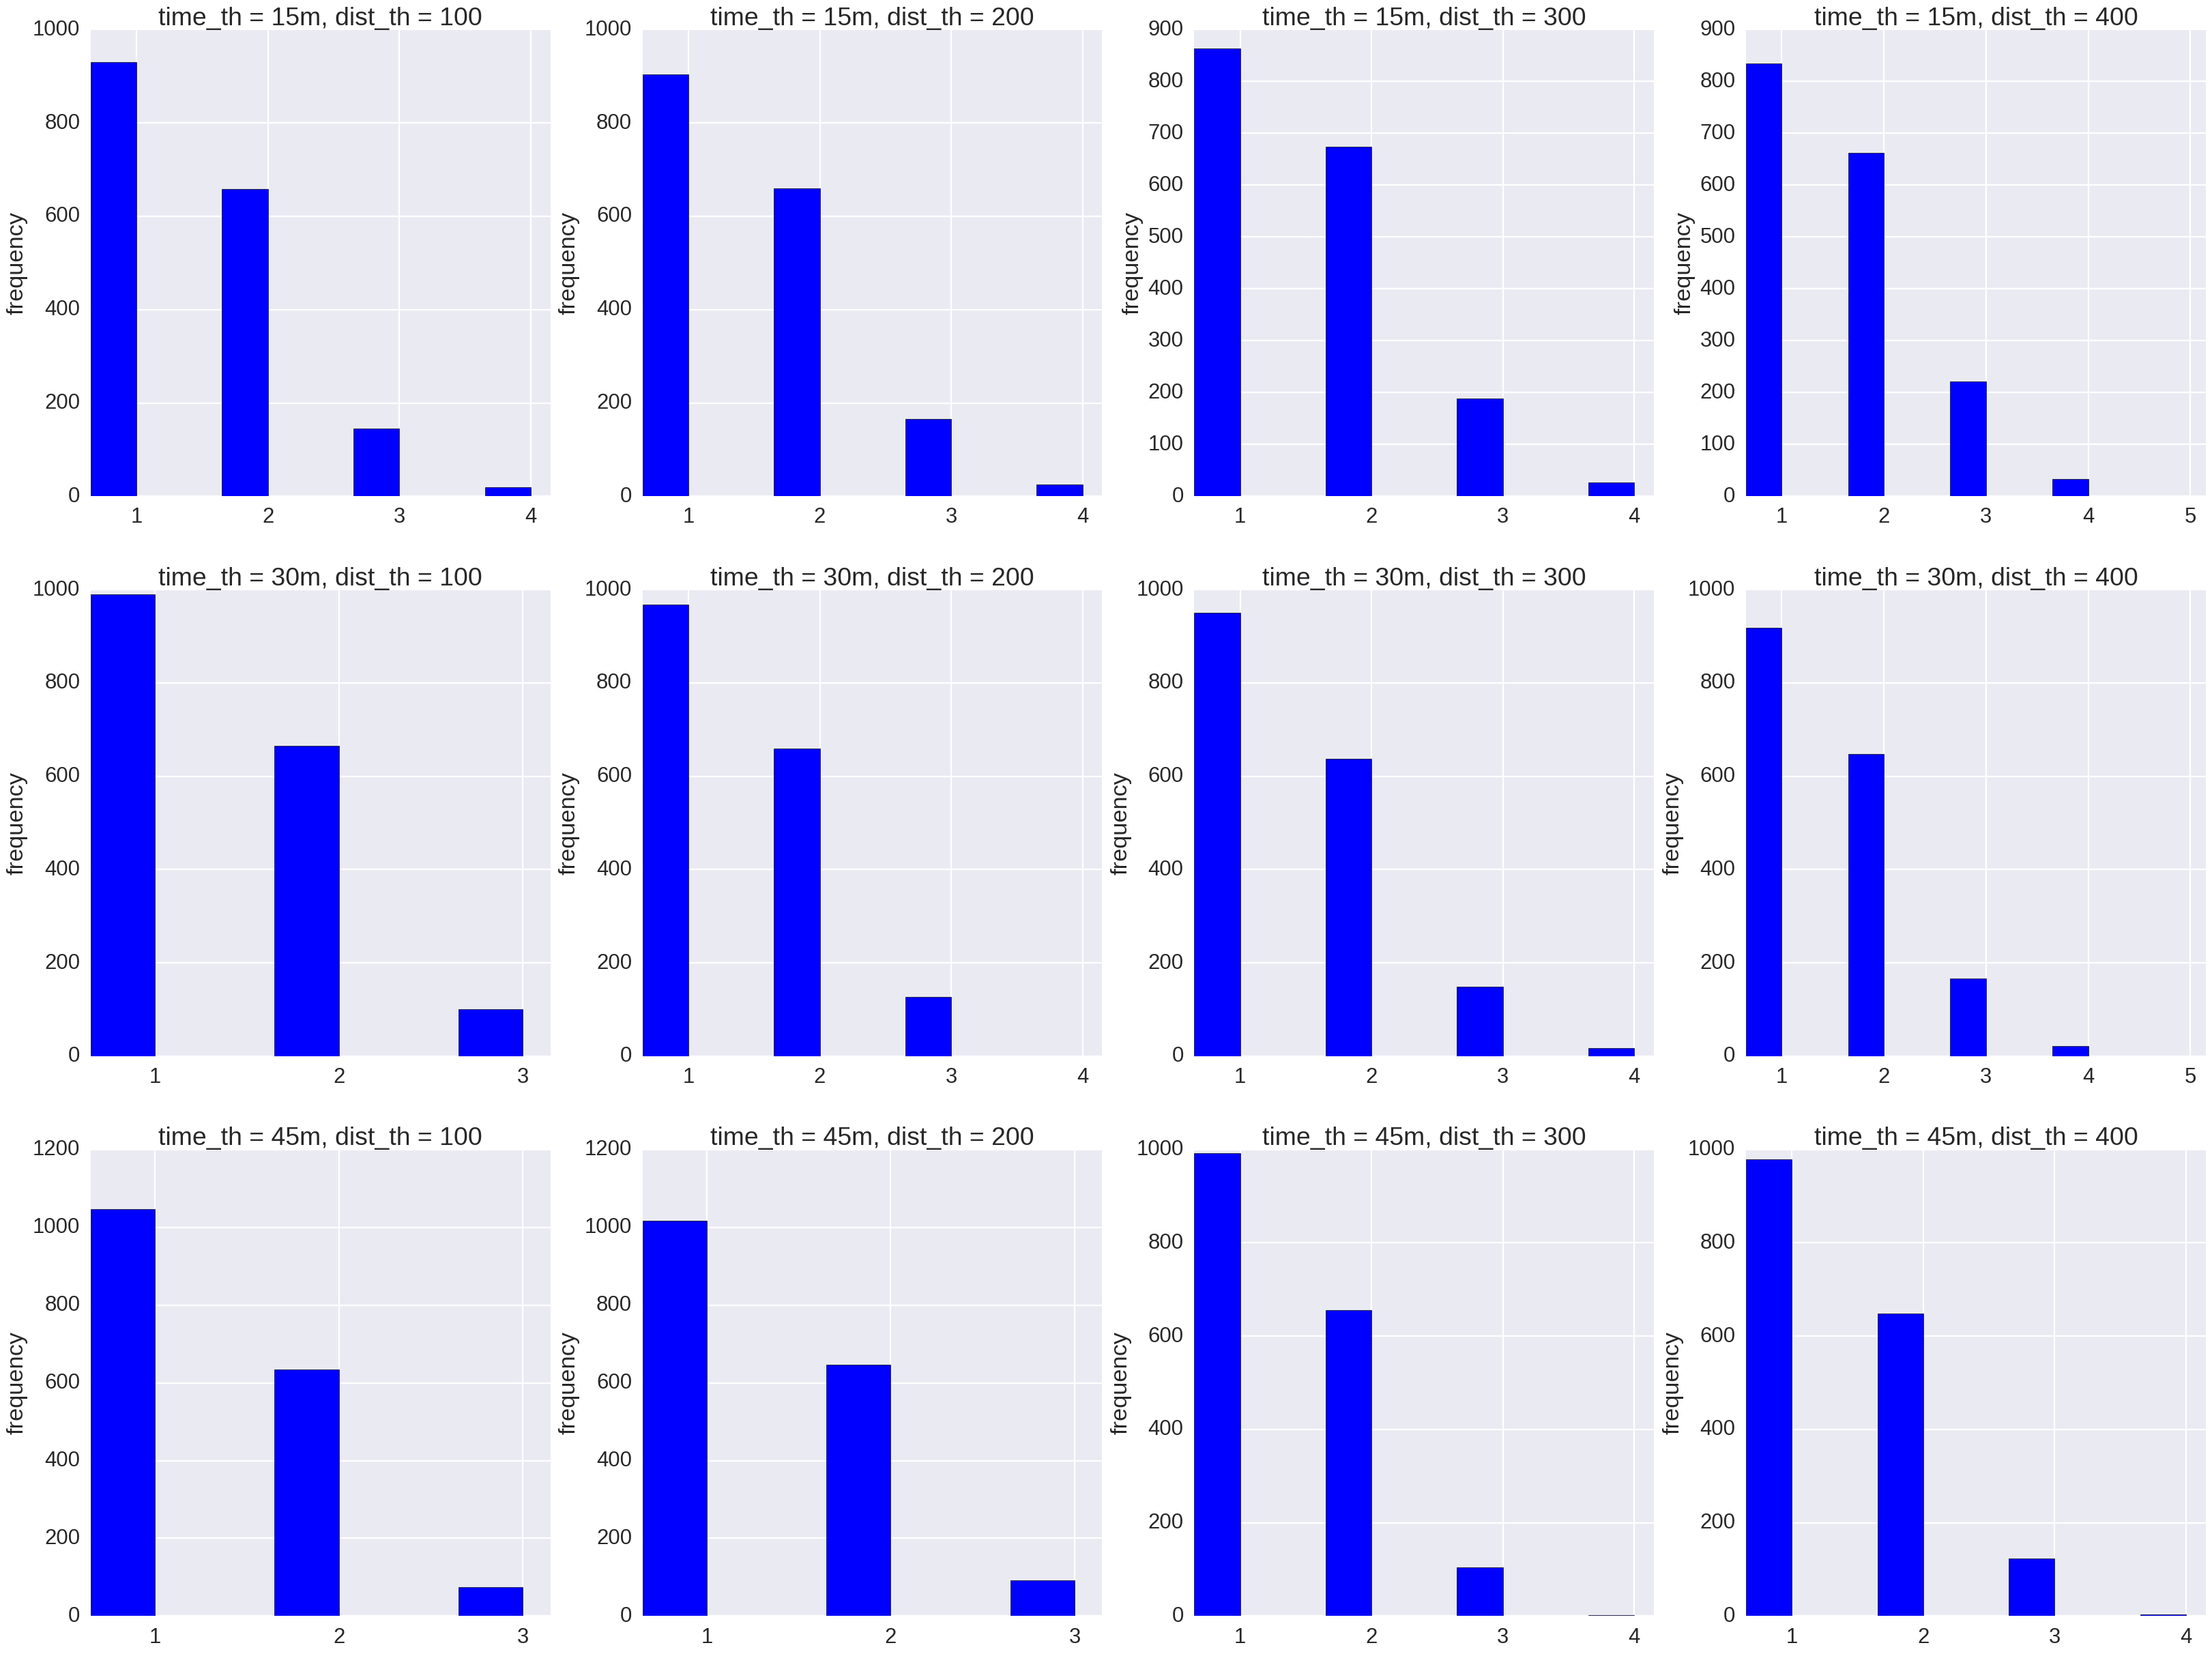

In [33]:
# graphs_all
num_daily_nodes

rows = len(time_ths)
cols = len(dist_ths)
number_graphs = rows * cols
fig = plt.figure(figsize=(cols*10, rows*10))

index = -1
for i in range(rows):
    for j in range(cols):
        index += 1
        ax = fig.add_subplot(rows, cols, index + 1)
        dd = num_daily_nodes[i][j]
        time_th,dist_th = time_ths[i],dist_ths[j]
        l = len(dd)
        nbarx = [0] * l
        nbary = [0] * l
        c = -1
        for k,v in dd.items():
            c += 1
            nbarx[c] = k
            nbary[c] = v
        ind = np.arange(l)  # the x locations for the groups
        width = 0.35       # the width of the bars
        rects1 = ax.bar(ind, nbary, width, color='b')
        # add some text for labels, title and axes ticks
        ax.set_ylabel('frequency')
        ax.set_title('time_th = {}, dist_th = {}'.format(time_th,dist_th))
        ax.set_xticks(ind + width)
        ax.set_xticklabels(nbarx)
#         ax.set_xlabel('number of daily nodes')
fig.savefig("num_daily_nodes2.pdf", format = 'pdf')
#         ax.legend((rects1[0], rects2[0]), ('Men', 'Women'))

### Plot motif wiht frequency (top 20) based on number of nodes 

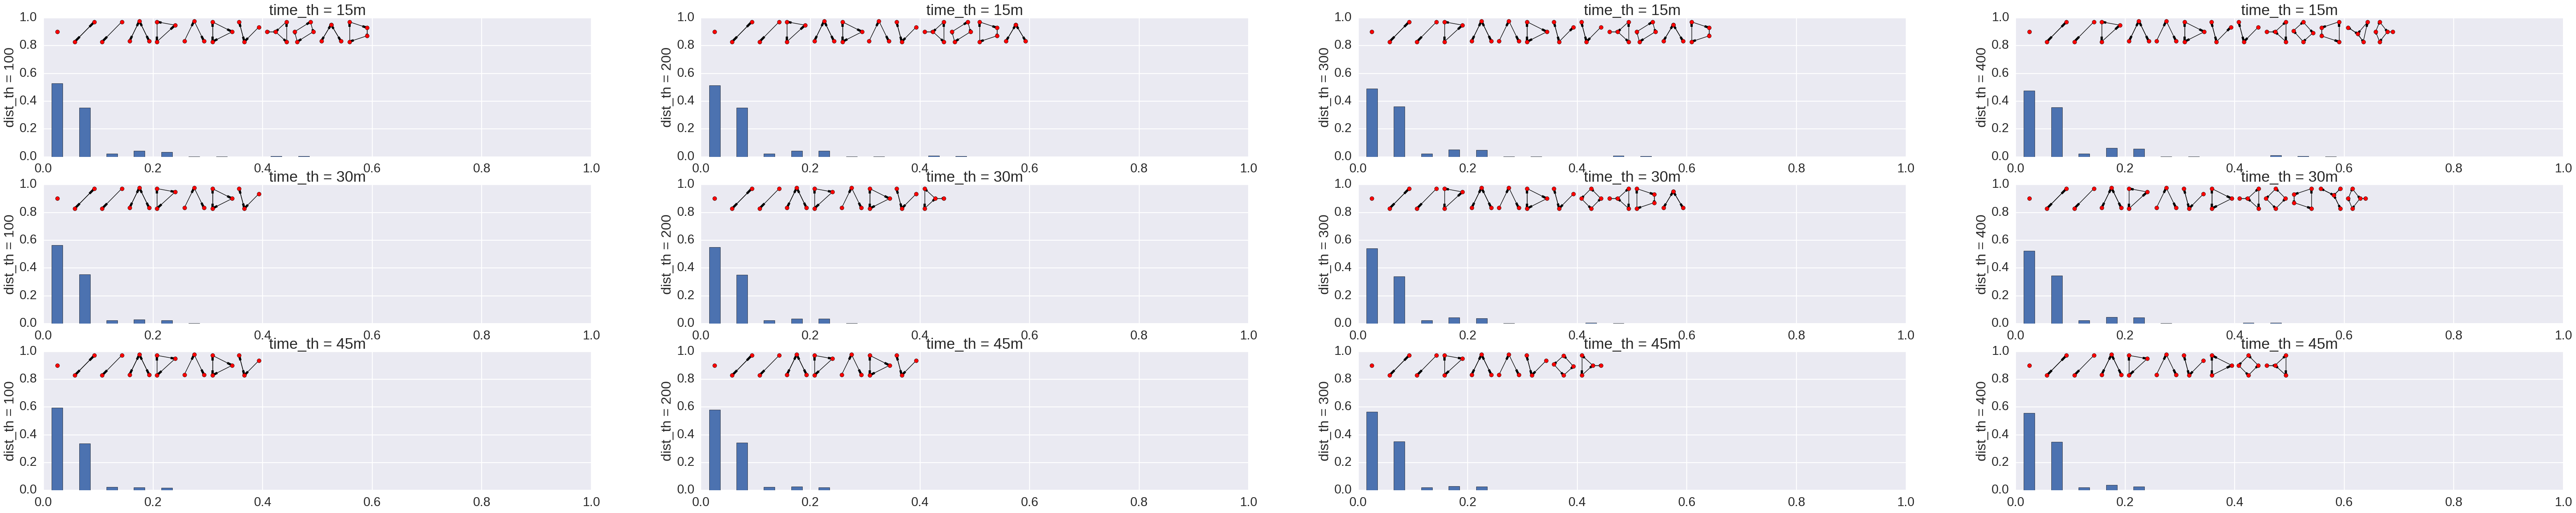

In [34]:
cols = len(dist_ths)
rows = len(time_ths)
fig = plt.figure(figsize=(cols*20, rows*5))
c = 0
w = 1 / 20
b_w = w * 0.4
bar_pos_diff = (w - b_w) / 2
for i in range(rows):
    for j in range(cols):

        c += 1
        ax = fig.add_subplot(rows,cols,c)
        
        d = graphs_all[i][j]
        d2 = d
        d2['n'] = [len(x.nodes()) for x in d.g]
        d2 = d2.sort_values('n')
        for index, row in enumerate(d2.iterrows()):
            subpos = [w*(index),0.8,w,0.2]
            subax = add_subplot_axes(ax,subpos)
            if row[1].n == 0:
                a = nx.DiGraph()
                a.add_node('1')
                nx.draw_spectral(a, ax=subax, node_size=50)
            else:
                nx.draw_spectral(row[1].g, ax=subax, node_size=50)
            
            p = patches.Rectangle((w*(index) + bar_pos_diff,0),b_w,row[1].pct/100)
            ax.add_patch(p)
            
        ax.set_title('time_th = {}'.format(time_ths[i]))
        ax.set_ylabel('dist_th = {}'.format(dist_ths[j],rotation = 'vertical'))

# fig.suptitle('sorted by number of nodes')


In [35]:
fig.savefig("multiple_user.pdf3", format = 'pdf')

In [274]:
gg = graphs_all[0][0]
# f = sorted(d, key=lambda z: len(z['g'].nodes()))
gg.g[0].nodes()
gg2 = gg
gg2['n'] = [len(x.nodes()) for x in gg.g]
gg2
gg2.sort_values('n')

,g,total,pct,n
0,(),1147,70.933828,0
1,"(dr5xdjc, dr5x8d2)",352,21.768707,2
2,"(dr78080, dr5xdjc, dr5rzgy)",87,5.380334,3
4,"(dr5xckk, dr5xdjc, dr5xbbq)",12,0.742115,3
6,"(dr5xdjc, dr5x8d2, dr5xfdt)",2,0.123686,3
3,"(dr5rxth, dr5xbbq, dr5xdjc, dr5xfdt)",13,0.803958,4
5,"(dr5rxth, dr5xdjc, dr5xfdt, dr5xbbq)",3,0.185529,4
7,"(dr5xckk, dr5xdjc, dr5xdw5, dr5rxth)",1,0.061843,4


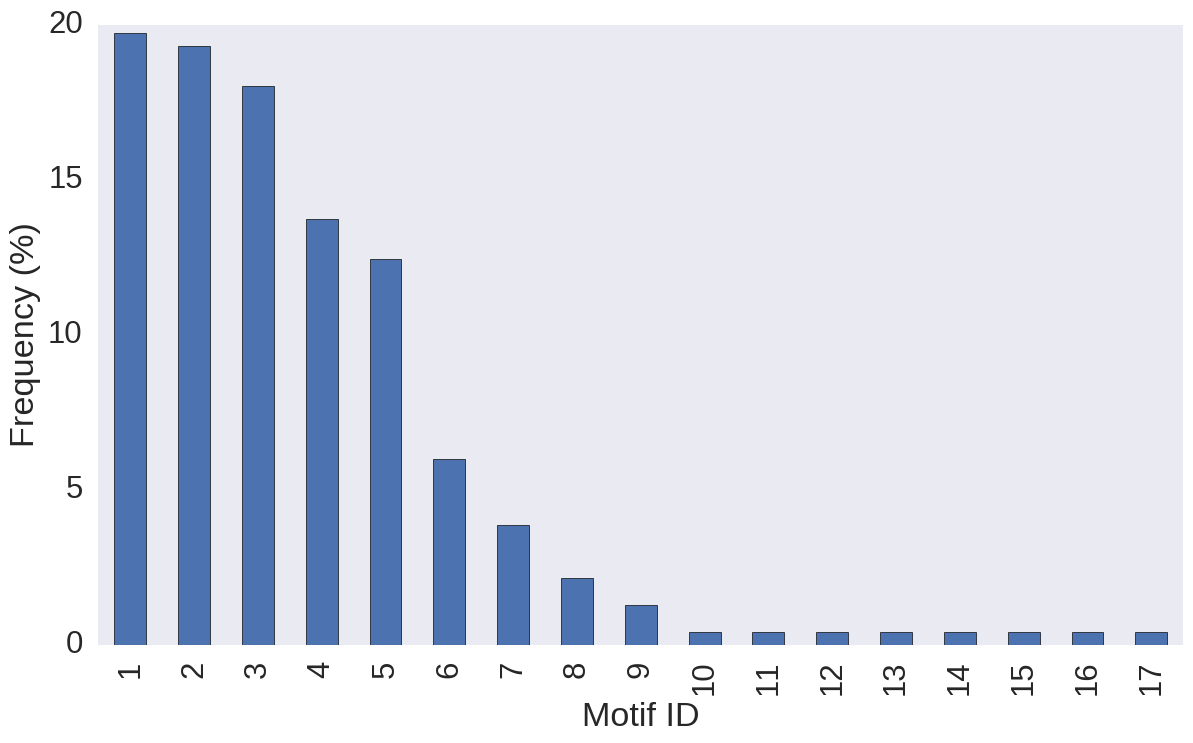

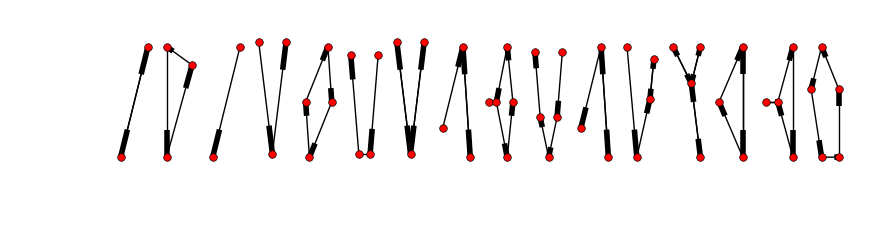

In [34]:
num_locations = []

for fid in test_data:
    eureka_location_data = prefix + fid
    eureka = pd.read_csv(eureka_location_data, 
                     usecols=['time', 'longitude', 'latitude','geo_hash'])
    eureka = anvil.api.convert_time_zone(eureka, 'time')
    y = eureka.copy()
    y['stay_point'] = get_stay_point(y, dist_th = dist_th,time_th = time_th)
    y['stay_region'] = get_stay_region(y)
    
    num_locations.append(len(np.unique(y.stay_region.dropna())))
    
    nodes = generate_daily_nodes(y.dropna(subset=['stay_region']), 'stay_region')

    # Only retain days with enough information
    # (i.e., at least 8 non-null intervals)
    nodes_h = [z for z in nodes if len(z[1].dropna()) > 8]

    cols = 15
    rows = 8
    number_graphs = rows * cols
    fig = plt.figure(figsize=(cols*2, rows*2))
    
    # Equality of generated graphs
    graphs = {}
    for index, n in enumerate(nodes_h):
        found = False
        g = set(generate_graph(n[1].node)) # removes duplicates
        dg = nx.DiGraph()
        # each node in the edge is seperated by whitespace
        dg.add_edges_from([t.split() for t in g]) 
        dg = nx.freeze(dg)

        for graph in graphs:
            if nx.is_isomorphic(graph, dg):
                # Found an isomorphic graph
                found = True
                graphs[graph].append(dg)
                break
        if not found:
            # No isomorphic graph so far, so
            # create a new one
            graphs[dg] = [dg]
    
    # Sort by motif frequency
    d = []
    for k, v in graphs.items():
        d.append({'g': k, 'total': len(v)})

    d = sorted(d, key=lambda z: z['total'], reverse=True)
    
    # Generate motif frequency percentage bar plot
    # (limited to top 20 motifs)

    t = pd.DataFrame(d[:20])
    t['pct'] = t.total / t.total.sum() * 100
    fig = plt.figure(figsize=(14, 8))
    with sns.axes_style('dark'):
        ax = fig.add_subplot(111)
        t.plot(y='pct', kind='bar', ax=ax)
        ax.set_xticklabels(np.arange(1, 21, 1))
        ax.legend([])
        ax.set_ylabel('Frequency (%)')
        ax.set_xlabel('Motif ID')
    
    # Draw motifs sorted by frequency

    fig = plt.figure(figsize=(10, 2))
    for index, g in enumerate(t.g):
        ax = fig.add_subplot(1, len(t), index + 1)
        nx.draw_spectral(g, ax=ax, node_size=30)
    
    break
    

In [36]:
num_locations

[83]

### eureka location data ###

In [25]:
eureka_location_data = './u010_rct@eureka.csv'
# eureka = pd.read_csv(eureka_location_data, 
#                      usecols=['uid', 'time', 'longitude', 'latitude'])
# eureka_location_data = './u054_rct@eureka.csv'
eureka = pd.read_csv(eureka_location_data, 
                     usecols=['time', 'longitude', 'latitude'])
len(eureka)

34017

In [58]:
# convert timezone to ET

eureka = anvil.api.convert_time_zone(eureka, 'time')

In [59]:
# generate geo hash
eureka['geo_hash'] = compute_geo_hash(eureka, lat_c='latitude',
                                      lon_c='longitude', precision=8)

### Draw significant places from location data ###

In [60]:
eureka_hash = pd.Series(filter_out_rare_points(eureka.geo_hash))

In [61]:
l = eureka_hash.dropna().unique()
print('No. of unique places: {0}'.format(len(l)))
x = [geohash.decode(t) for t in l]
map_view = folium.Map(x[0])

folium.LatLngPopup().add_to(map_view)
for p in x:
    folium.Marker(p).add_to(map_view)

No. of unique places: 17


In [43]:
# map_view.save('/tmp/ureka-viz/ureka-u010.html')

## Get stay points and stay regions (100m and 30 mins)

In [62]:
# eureka_location_data = '/tmp/u010_rct@eureka.csv'
# eureka = pd.read_csv(eureka_location_data, 
#                      usecols=['uid', 'time', 'longitude', 'latitude'])

y = eureka.copy()

# Generate stay points with 30 mins and 100m threshold
y['stay_point'] = get_stay_point(y, dist_th=100)
y['stay_region'] = get_stay_region(y)

### Generate daily network motifs ###

In [63]:
nodes = generate_daily_nodes(y.dropna(subset=['stay_region']), 'stay_region')

# Only retain days with enough information
# (i.e., at least 8 non-null intervals)
nodes_h = [z for z in nodes if len(z[1].dropna()) > 8]

# cols = 15
# rows = 8
# number_graphs = rows * cols
# fig = plt.figure(figsize=(cols*2, rows*2))

# for index, n in enumerate(nodes_h[:number_graphs]):
#     ax = fig.add_subplot(cols, rows, index + 1)
#     g = set(generate_graph(n[1].node))  # removes duplicates
#     dg = nx.DiGraph()
    
#     # each node in the edge is seperated by whitespace
#     dg.add_edges_from([t.split() for t in g])
#     nx.draw_spectral(dg, ax=ax, node_size=30)

In [85]:
node = nodes_h[0]
print(type(nodes_h))

<class 'list'>


### Checking motif frequency ###

For calculating motif frequency, we need to determine if two
generated graphs are equal. In our case, this equality tests
boils down to isomorphism [1]. In other words, we do not
care about the node labels, but just the edge equivalency here.

[1]: https://en.wikipedia.org/wiki/Graph_isomorphism

In [46]:
# Equality of generated graphs

graphs = {}
for index, n in enumerate(nodes_h):
    found = False
    g = set(generate_graph(n[1].node)) # removes duplicates
    dg = nx.DiGraph()
    # each node in the edge is seperated by whitespace
    dg.add_edges_from([t.split() for t in g]) 
    dg = nx.freeze(dg)
    
    for graph in graphs:
        if nx.is_isomorphic(graph, dg):
            # Found an isomorphic graph
            found = True
            graphs[graph].append(dg)
            break
    if not found:
        # No isomorphic graph so far, so
        # create a new one
        graphs[dg] = [dg]

In [47]:
# Sort by motif frequency
d = []
for k, v in graphs.items():
    d.append({'g': k, 'total': len(v)})

d = sorted(d, key=lambda z: z['total'], reverse=True)

In [21]:
# # Generate motif frequency bar plot
# # (limited to top 20 motifs)

# t = pd.DataFrame(d[:20])
# t['pct'] = t.total / t.total.sum() * 100
# fig = plt.figure(figsize=(14, 8))
# with sns.axes_style('dark'):
#     ax = fig.add_subplot(111)
#     t.plot(y='total', kind='bar', ax=ax)
#     ax.set_xticks([])
#     ax.legend([])
#     ax.set_ylabel('Count')

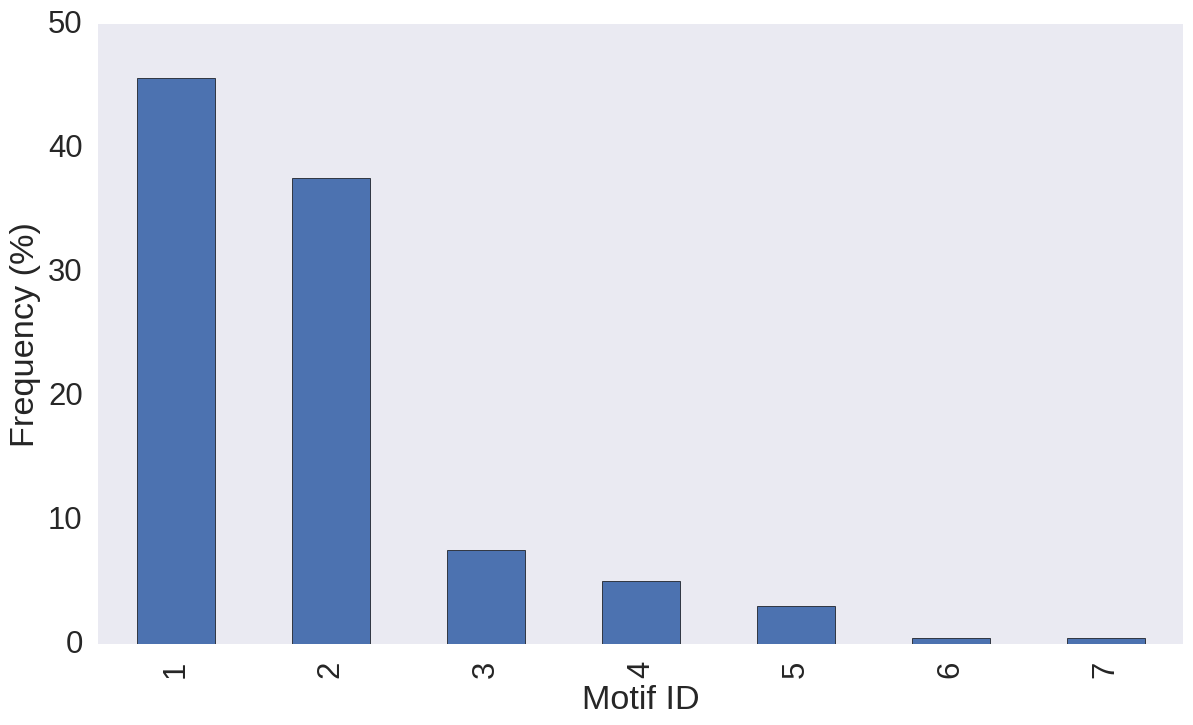

In [49]:
# Generate motif frequency percentage bar plot
# (limited to top 20 motifs)

t = pd.DataFrame(d[:20])
t['pct'] = t.total / t.total.sum() * 100
fig = plt.figure(figsize=(14, 8))
with sns.axes_style('dark'):
    ax = fig.add_subplot(111)
    t.plot(y='pct', kind='bar', ax=ax)
    ax.set_xticklabels(np.arange(1, 21, 1))
    ax.legend([])
    ax.set_ylabel('Frequency (%)')
    ax.set_xlabel('Motif ID')

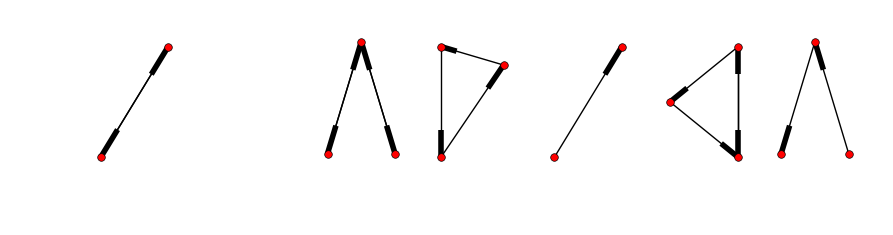

In [50]:
# Draw motifs sorted by frequency

fig = plt.figure(figsize=(10, 2))
for index, g in enumerate(t.g):
    ax = fig.add_subplot(1, len(t), index + 1)
    nx.draw_spectral(g, ax=ax, node_size=30)

### Generate motif sorted by node count ###

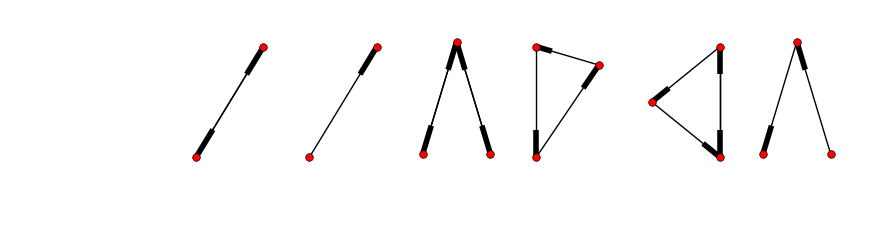

In [51]:
# First get the top-20 motifs by frequency count
d = []
for k, v in graphs.items():
    d.append({'g': k, 'total': len(v)})
d = sorted(d, key=lambda z: z['total'], reverse=True)

# Now sort these motifs by node count

f = sorted(d[:20], key=lambda z: len(z['g'].nodes()))

fig = plt.figure(figsize=(10, 2))
for index, ff in enumerate(f):
    g = ff['g']
    ax = fig.add_subplot(1, len(f), index + 1)
    nx.draw_spectral(g, ax=ax, node_size=30)

In [244]:
d

,g,total,pct
0,(),1147,70.933828
1,"(dr5xdjc, dr5x8d2)",352,21.768707
2,"(dr78080, dr5xdjc, dr5rzgy)",87,5.380334
3,"(dr5rxth, dr5xbbq, dr5xdjc, dr5xfdt)",13,0.803958
4,"(dr5xckk, dr5xdjc, dr5xbbq)",12,0.742115
5,"(dr5rxth, dr5xdjc, dr5xfdt, dr5xbbq)",3,0.185529
6,"(dr5xdjc, dr5x8d2, dr5xfdt)",2,0.123686
7,"(dr5xckk, dr5xdjc, dr5xdw5, dr5rxth)",1,0.061843


## Get stay points and stay regions (100m and 10 mins)

In [52]:
y = eureka.copy()

# Generate stay points with 30 mins and 100m threshold
y['stay_point'] = get_stay_point(y, dist_th=100, time_th='10m')
y['stay_region'] = get_stay_region(y)

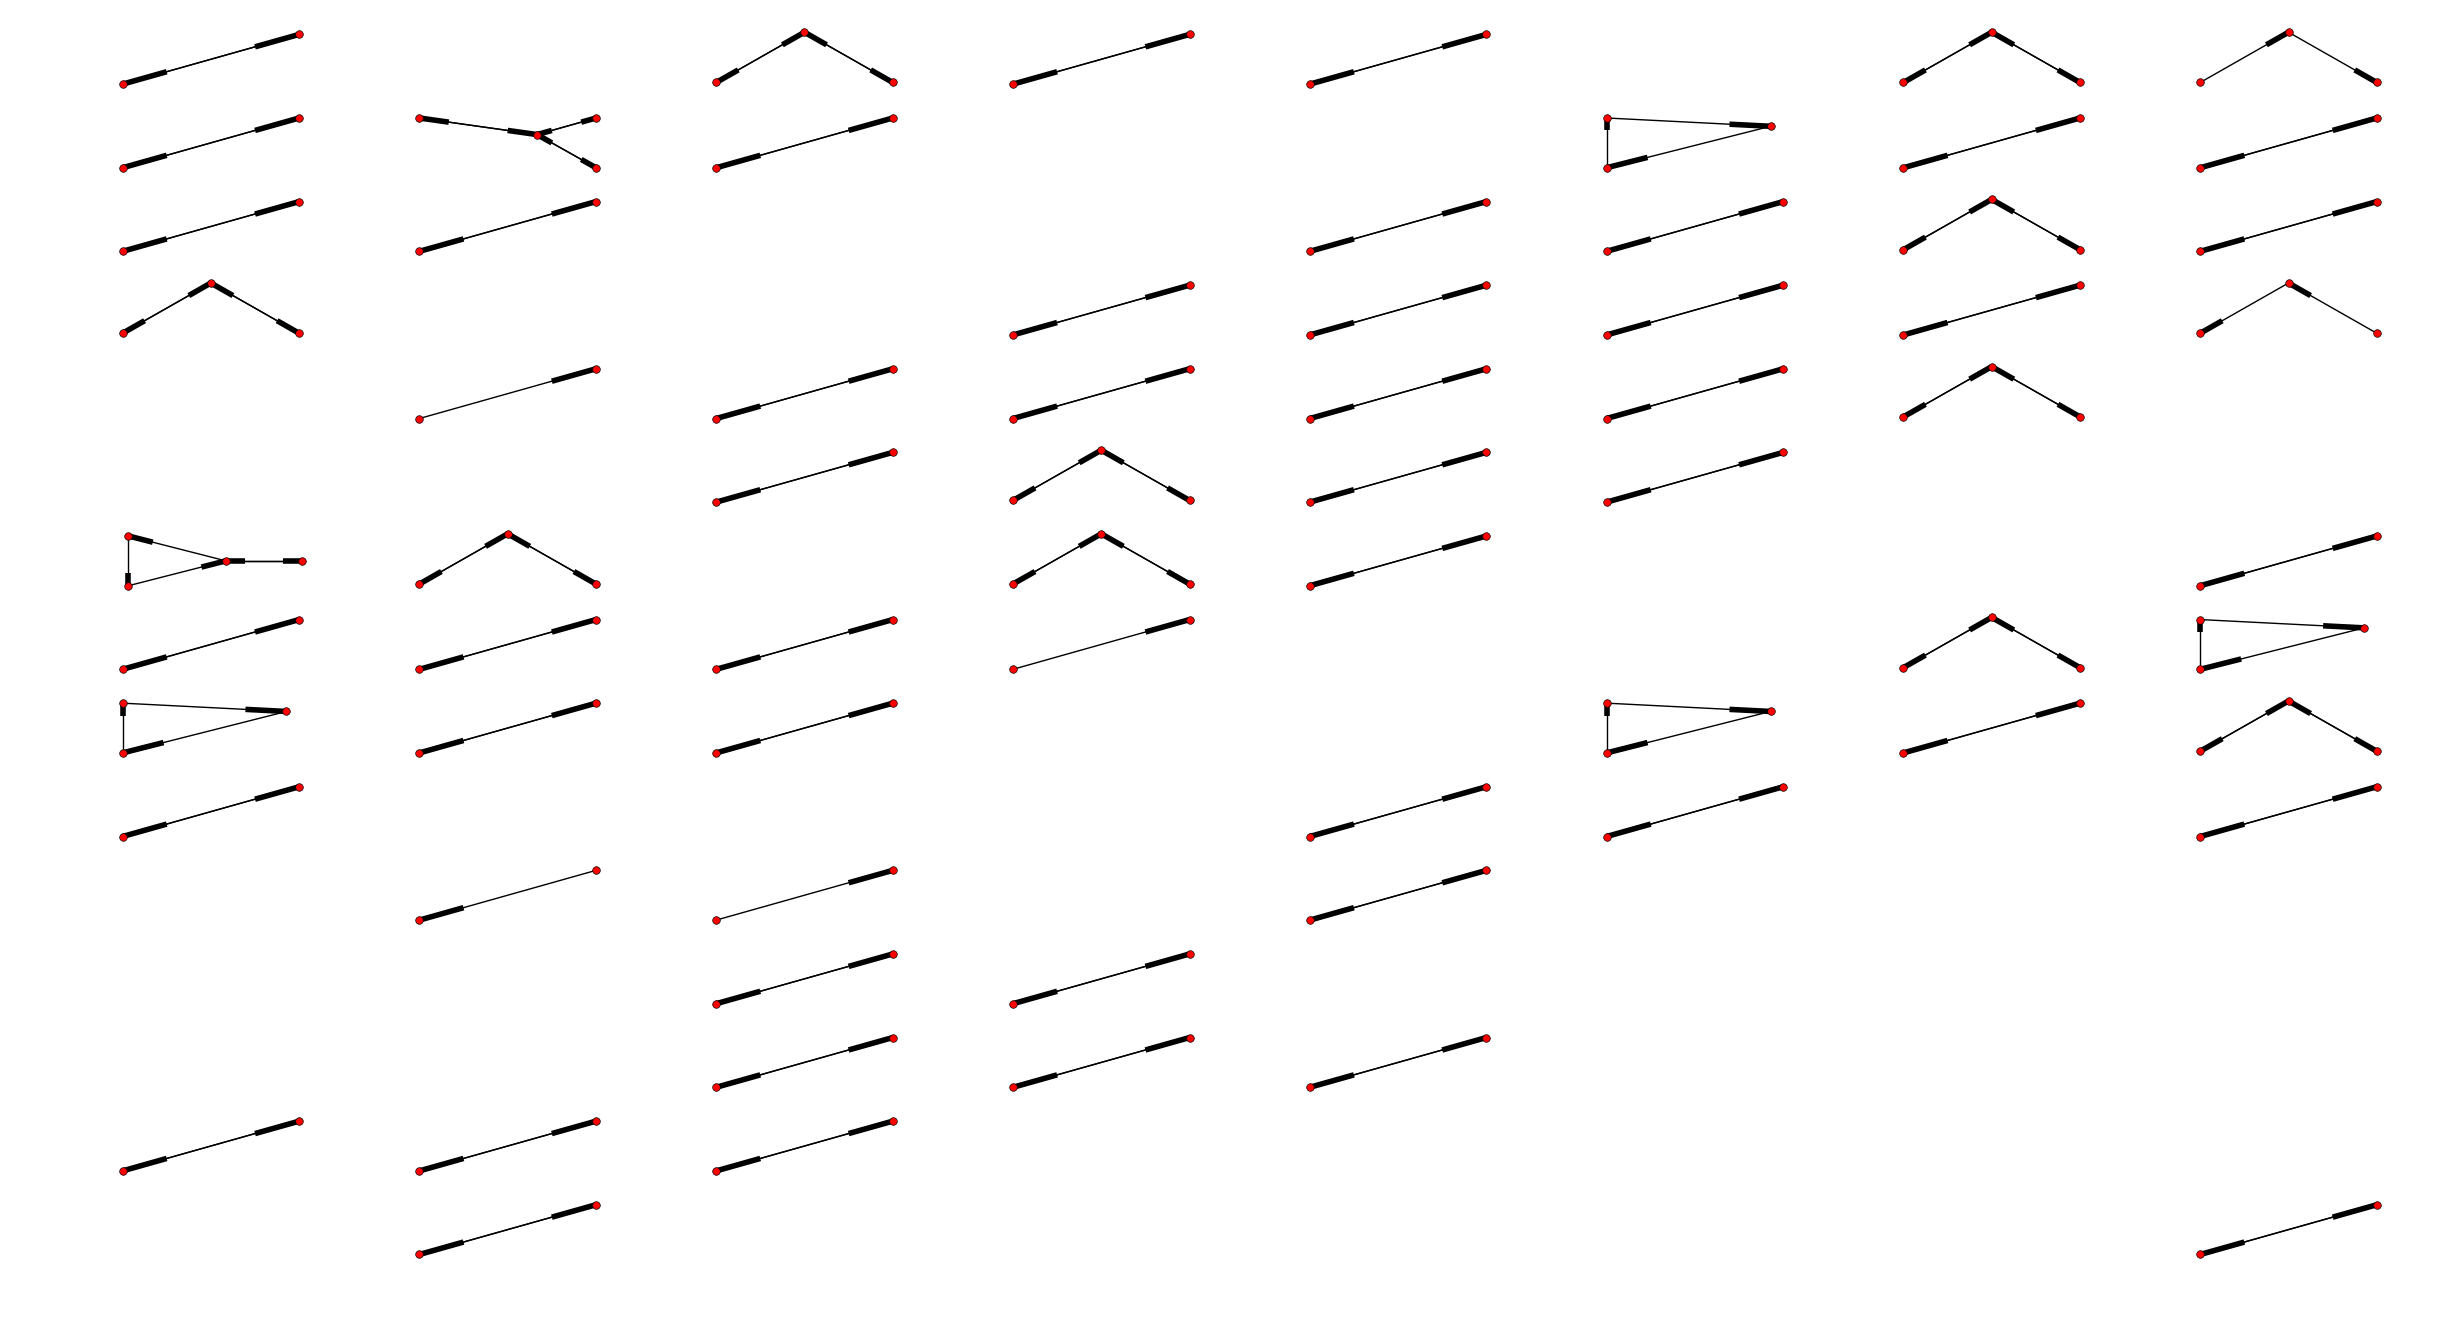

In [53]:
nodes = generate_daily_nodes(y.dropna(subset=['stay_region']), 'stay_region')

# Only retain days with enough information
# (i.e., at least 8 non-null intervals)
nodes_h = [z for z in nodes if len(z[1].dropna()) > 8]

cols = 15
rows = 8
number_graphs = rows * cols
fig = plt.figure(figsize=(cols*2, rows*2))

for index, n in enumerate(nodes_h[:number_graphs]):
    ax = fig.add_subplot(cols, rows, index + 1)
    g = set(generate_graph(n[1].node))  # removes duplicates
    dg = nx.DiGraph()
    
    # each node in the edge is seperated by whitespace
    dg.add_edges_from([t.split() for t in g])
    nx.draw_spectral(dg, ax=ax, node_size=30)

In [54]:
# Equality of generated graphs

graphs = {}
for index, n in enumerate(nodes_h):
    found = False
    g = set(generate_graph(n[1].node)) # removes duplicates
    dg = nx.DiGraph()
    # each node in the edge is seperated by whitespace
    dg.add_edges_from([t.split() for t in g]) 
    dg = nx.freeze(dg)
    
    for graph in graphs:
        if nx.is_isomorphic(graph, dg):
            # Found an isomorphic graph
            found = True
            graphs[graph].append(dg)
            break
    if not found:
        # No isomorphic graph so far, so
        # create a new one
        graphs[dg] = [dg]

# Sort by motif frequency
d = []
for k, v in graphs.items():
    d.append({'g': k, 'total': len(v)})

d = sorted(d, key=lambda z: z['total'], reverse=True)

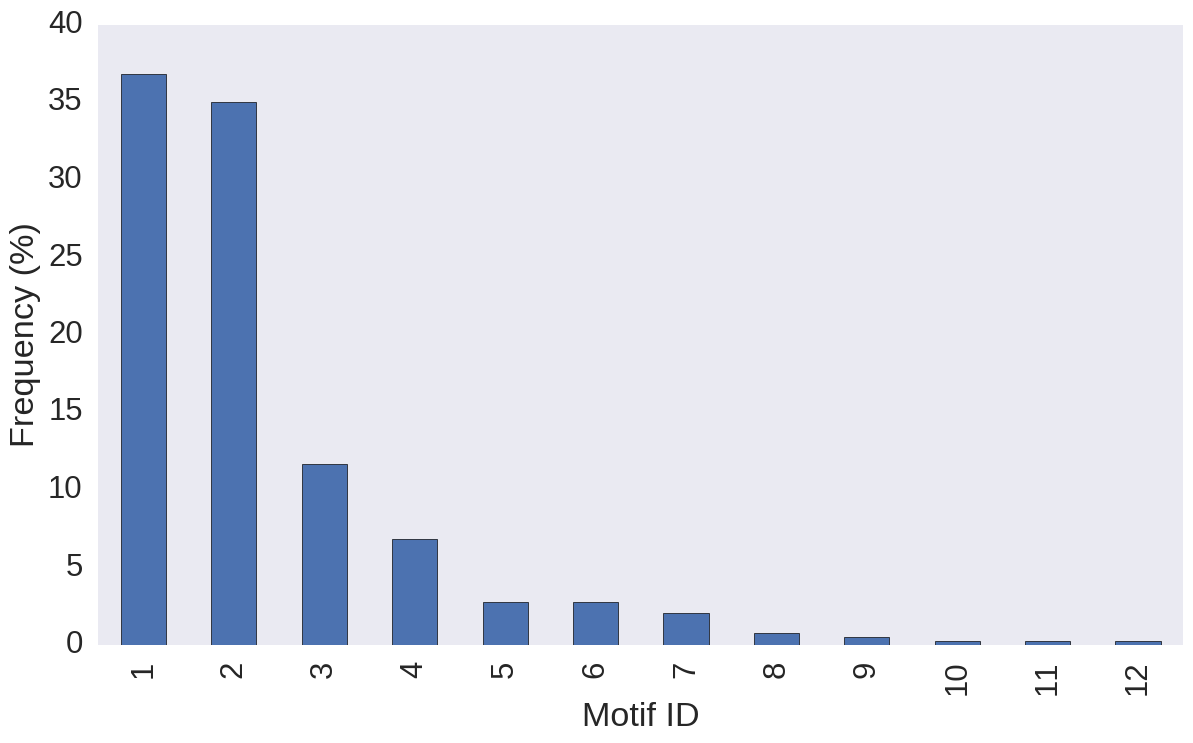

In [55]:
# Generate motif frequency percentage bar plot
# (limited to top 20 motifs)

t = pd.DataFrame(d[:20])
t['pct'] = t.total / t.total.sum() * 100
fig = plt.figure(figsize=(14, 8))
with sns.axes_style('dark'):
    ax = fig.add_subplot(111)
    t.plot(y='pct', kind='bar', ax=ax)
    ax.set_xticklabels(np.arange(1, 21, 1))
    ax.legend([])
    ax.set_ylabel('Frequency (%)')
    ax.set_xlabel('Motif ID')

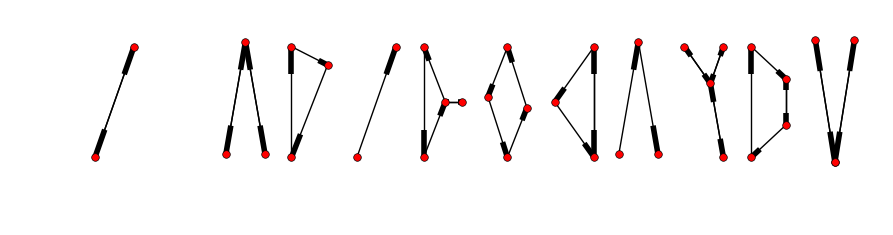

In [56]:
# Draw motifs sorted by frequency

fig = plt.figure(figsize=(10, 2))
for index, g in enumerate(t.g):
    ax = fig.add_subplot(1, len(t), index + 1)
    nx.draw_spectral(g, ax=ax, node_size=30)

In [70]:
a = 2
b = 11

In [1]:
a = t.ix[2,'g']
# nx.draw_spectral(a, node_size=30)

NameError: name 't' is not defined

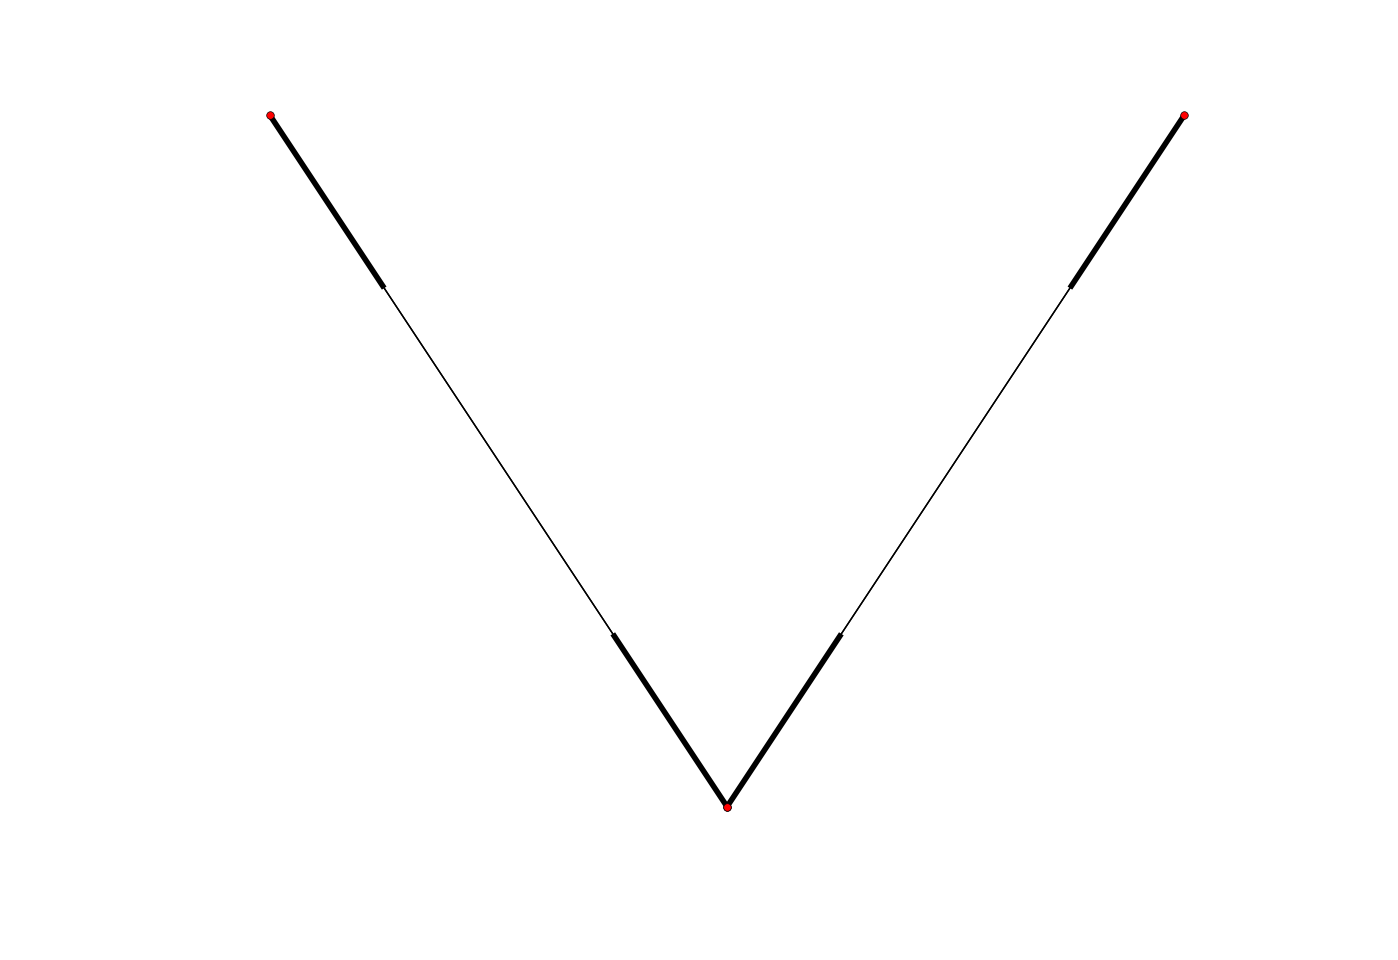

In [86]:
a = t.ix[11,'g']
nx.draw_spectral(a, node_size=30)

In [87]:
a = t.ix[11,'g']
A = nx.adjacency_matrix(a)
print(A.todense())

[[0 0 1 1]
 [1 0 0 0]
 [0 0 0 1]
 [1 1 0 0]]


In [267]:
a = list('abcd')
b = range(4)
df = pd.DataFrame()
df['A'] = a
df['b'] = b
df = df.set_index('A')
df

,b
A,
a,0
b,1
c,2
d,3


In [271]:
df2 = df
df2['s'] = [x * -1 for x in df.b]
df2

,b,s
A,,
a,0,0
b,1,-1
c,2,-2
d,3,-3


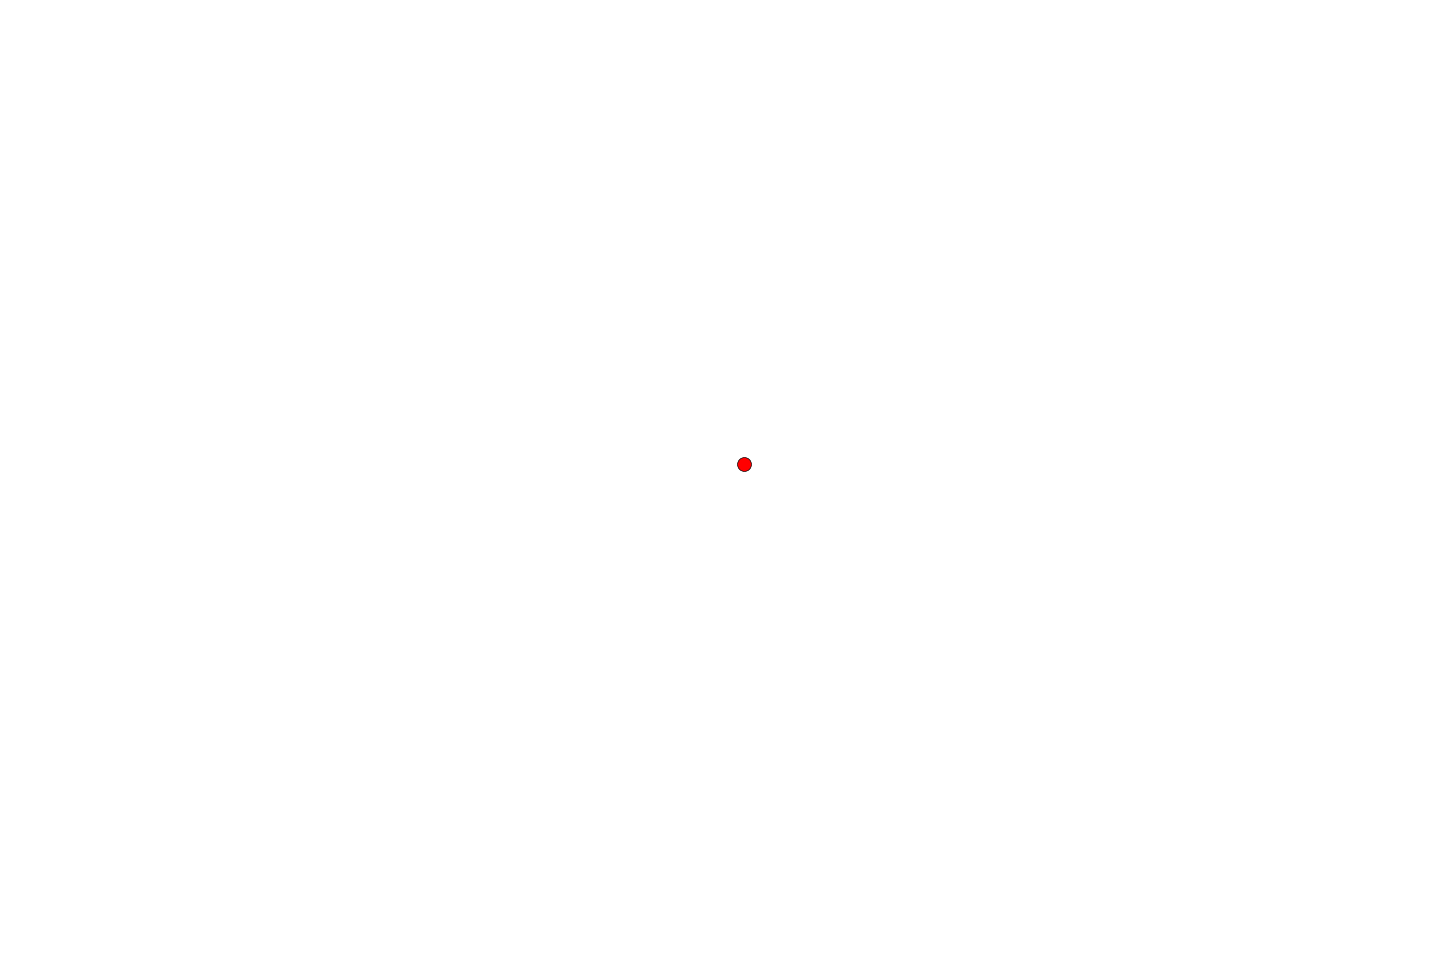

In [285]:
g = nx.DiGraph()
g.add_node('a')
# g.add_edge(1,1)
nx.draw_spectral(g, node_size=100)